# Training Gym agents using distributed RL training across multiple nodes with Amazon SageMaker

In [1]:
# Uncomment the problem to work on
# gym_problem = 'cartpole'
gym_problem = 'pong'

## Pre-requisites 

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [2]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML, Markdown
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from markdown_helper import generate_help_for_s3_endpoint_permissions, create_s3_endpoint_manually

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [3]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-ap-northeast-1-669108200413/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [4]:
# create a descriptive job name 
job_name_prefix = 'rl-gym-distributed-' + gym_problem
aws_region = boto3.Session().region_name

### Configure where training happens

You can train your RL training jobs using the SageMaker notebook instance or local notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`.

In [5]:
# run in local_mode on this machine, or as a SageMaker TrainingJob?
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.c5.2xlarge"
    
train_instance_count = 3

### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

In [6]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::669108200413:role/service-role/AmazonSageMaker-ExecutionRole-20190324T002031


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker and docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [7]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Build docker container

We must build a custom docker container with Gym[Atari] installed.  This takes care of everything:

1. Fetching base container image
2. Installing Gym[Atari] and its dependencies
3. Uploading the new container image to ECR

This step can take a long time if you are running on a machine with a slow internet connection.  If your notebook instance is in SageMaker or EC2 it should take 3-10 minutes depending on the instance type.


In [10]:
%%time

cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-gym-ray-%s" % cpu_or_gpu
docker_build_args = {
    'CPU_OR_GPU': cpu_or_gpu, 
    'AWS_REGION': boto3.Session().region_name,
}
custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using ECR image %s" % custom_image_name)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
Building docker image sagemaker-gym-ray-cpu from Dockerfile
$ docker build -t sagemaker-gym-ray-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=ap-northeast-1
Sending build context to Docker daemon  399.4kB
Step 1/11 : ARG CPU_OR_GPU
Step 2/11 : ARG AWS_REGION
Step 3/11 : FROM 520713654638.dkr.ecr.${AWS_REGION}.amazonaws.com/sagemaker-rl-tensorflow:ray0.5.3-${CPU_OR_GPU}-py3
 ---> b522ab9d6e52
Step 4/11 : WORKDIR /opt/ml
 ---> Using cache
 ---> 7de5ca413e4b
Step 5/11 : RUN apt-get update && apt-get install -y       git cmake ffmpeg pkg-config       qtbase5-dev libqt5opengl5-dev libassimp-dev       libpython3.5-dev libtinyxml-dev     && cd 

## Write the Training Code

The training code is in a series of 
The training code is written in the file “train-{gym_problem}.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function. 

In [12]:
!pygmentize src/train-{gym_problem}.py

Error: cannot read infile: [Errno 2] No such file or directory: 'src/train-{gym_problem}.py'


## Ray homogeneous scaling - Specify train_instance_count > 1

Homogeneous scaling allows us to use multiple instances of the same type.

In [11]:
metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)
    
estimator = RLEstimator(entry_point="train-%s.py" % gym_problem,
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=train_instance_count,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        hyperparameters={
                          # Attention scientists!  You can override any Ray algorithm parameter here:
                            
                            # 3 m4.2xl with 8 cores each. We have to leave 1 core for ray scheduler.
                            # Don't forget to change this on the basis of instance type.
                            "rl.training.config.num_workers": (8 * train_instance_count) - 1
                            
                          #"rl.training.config.horizon": 5000,
                          #"rl.training.config.num_sgd_iter": 10,
                        }
                    )

estimator.fit(wait=local_mode)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

INFO:sagemaker:Creating training-job with name: rl-gym-distributed-pong-2019-03-28-15-27-22-851


Training job: rl-gym-distributed-pong-2019-03-28-15-27-22-851


### Visualization

RL training can take a long time.  So while it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that.

In [13]:
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-gym-distributed-cartpole-2019-03-27-15-07-35-579
S3 job path: s3://sagemaker-ap-northeast-1-669108200413/rl-gym-distributed-cartpole-2019-03-27-15-07-35-579
Output.tar.gz location: s3://sagemaker-ap-northeast-1-669108200413/rl-gym-distributed-cartpole-2019-03-27-15-07-35-579/output/output.tar.gz
Intermediate folder path: s3://sagemaker-ap-northeast-1-669108200413/rl-gym-distributed-cartpole-2019-03-27-15-07-35-579/output/intermediate/
Create local folder /tmp/rl-gym-distributed-cartpole-2019-03-27-15-07-35-579


### Fetch videos of training rollouts
Videos of certain rollouts get written to S3 during training.  Here we fetch the last 10 videos from S3, and render the last one.

In [16]:
recent_videos = wait_for_s3_object(s3_bucket, intermediate_folder_key, tmp_dir, 
                                fetch_only=(lambda obj: obj.key.endswith(".mp4") and obj.size>0), limit=10)

Waiting for s3://sagemaker-ap-northeast-1-669108200413/rl-gym-distributed-cartpole-2019-03-27-15-07-35-579/output/intermediate/...
Only downloading 10 of 102 files


In [17]:
last_video = sorted(recent_videos)[-1]  # Pick which video to watch
os.system("mkdir -p ./src/tmp_render/ && cp {} ./src/tmp_render/last_video.mp4".format(last_video))
HTML('<video src="./src/tmp_render/last_video.mp4" controls autoplay></video>')

### Plot metrics for training job
We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in CloudWatch metrics.  We can plot this to see the performance of the model over time.

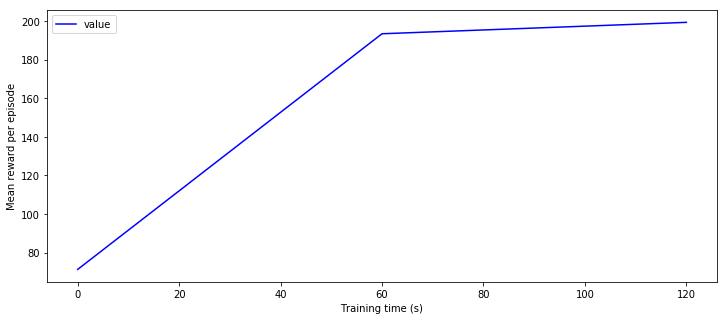

In [18]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
num_metrics = len(df)
if num_metrics == 0:
    print("No algorithm metrics found in CloudWatch")
else:
    plt = df.plot(x='timestamp', y='value', figsize=(12,5), legend=True, style='b-')
    plt.set_ylabel('Mean reward per episode')
    plt.set_xlabel('Training time (s)')

### Monitor training progress
You can repeatedly run the visualization cells to get the latest videos or see the latest metrics as the training job proceeds.

## Ray heterogeneous scaling

To scale out RL training, we can increase the number of rollout workers. However, with more rollouts, training can often become the bottleneck. To prevent this, we can use an instance with one or more GPUs for training, and multiple CPU instances for rollouts.

Since SageMaker supports a single type of instance in a training job, we can achieve the above by spinning two SageMaker jobs and letting them communicate with each other. For the sake of naming, we'll use `Primary cluster` to refer to 1 or more GPU instances, and `Secondary cluster` to refer to the cluster of CPU instances.

> Please note that local_mode cannot be used for testing this type of scaling.

Before we configure the SageMaker job, let us first ensure that we run SageMaker in VPC mode. VPC mode will allow the two SageMaker jobs to communicate over network.

This can be done by supplying subnets and security groups to the job launching scripts. We will use the default VPC configuration for this example.

In [ ]:
ec2 = boto3.client('ec2')
default_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

default_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                   if group["GroupName"] == "default" and group["VpcId"] == default_vpc]

default_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                  if subnet["VpcId"] == default_vpc and subnet['DefaultForAz']==True]

print("Using default VPC:", default_vpc)
print("Using default security group:", default_security_groups)
print("Using default subnets:", default_subnets)

A SageMaker job running in VPC mode cannot access S3 resources. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [ ]:
try:
    route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                if route_table['VpcId'] == default_vpc]
except Exception as e:
    if "UnauthorizedOperation" in str(e):
        display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
    else:
        display(Markdown(create_s3_endpoint_manually(aws_region, default_vpc)))
    raise e

print("Trying to attach S3 endpoints to the following route tables:", route_tables)

assert len(route_tables) >= 1, "No route tables were found. Please follow the VPC S3 endpoint creation "\
                              "guide by clicking the above link."

try:
    ec2.create_vpc_endpoint(DryRun=False,
                           VpcEndpointType="Gateway",
                           VpcId=default_vpc,
                           ServiceName="com.amazonaws.{}.s3".format(aws_region),
                           RouteTableIds=route_tables)
    print("S3 endpoint created successfully!")
except Exception as e:
    if "RouteAlreadyExists" in str(e):
        print("S3 endpoint already exists.")
    elif "UnauthorizedOperation" in str(e):
        display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
        raise e
    else:
        display(Markdown(create_s3_endpoint_manually(aws_region, default_vpc)))
        raise e

### Configure instance types

Let us configure a cluster with 1 Volta (V100) GPU and 40 CPU cores. We can do this by using 1 ml.p3.2xlarge instance and 2 ml.c5.4xlarge instances, since ml.p3.2xlarge has 8 CPU cores and ml.c5.4xlarge has 16 CPU cores.

In [ ]:
%%time

# Build CPU image
cpu_repository_short_name = "sagemaker-gym-ray-%s" % "cpu"
docker_build_args = {
    'CPU_OR_GPU': "cpu", 
    'AWS_REGION': boto3.Session().region_name,
}
cpu_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using CPU ECR image %s" % cpu_image_name)

# Build GPU image
gpu_repository_short_name = "sagemaker-gym-ray-%s" % "gpu"
docker_build_args = {
    'CPU_OR_GPU': "gpu", 
    'AWS_REGION': boto3.Session().region_name,
}
gpu_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using GPU ECR image %s" % gpu_image_name)

In [ ]:
primary_cluster_instance_type = "ml.p3.2xlarge"
primary_cluster_instance_count = 1

secondary_cluster_instance_type = "ml.c5.4xlarge"
secondary_cluster_instance_count = 2

total_cpus = 40 - 1 # Leave one for ray scheduler
total_gpus = 1

Next, we choose the gym agent that we want to train. For heterogeneous training, we also pass some additional parameters to the training job that aid in synchronization across instances:
- s3_bucket, s3_prefix: Used for storing metadata like master IP address
- rl_cluster_type: "primary" or "secondary"
- aws_region: This is required for making connection to S3 in VPC mode
- rl_num_instances_secondary: Number of nodes in secondary cluster
- subnets, security_group_ids: Required by VPC mode

In [13]:
gym_problem = 'cartpole'
job_name_prefix = 'rl-gym-distributed-'+ gym_problem

s3_output_path = 's3://{}/'.format(s3_bucket) # SDK appends the job name and output folder

# We explicitly need to specify these params so that the two jobs can synchronize using the metadata stored here
s3_bucket = sage_session.default_bucket()
s3_prefix = "dist-ray-%s-1GPU-40CPUs" % (gym_problem)

# Make sure that the prefix is empty
!aws s3 rm --recursive s3://{s3_bucket}/{s3_prefix}    

### Launch primary cluster (1 GPU training instance)

In [ ]:
primary_cluster_estimator = RLEstimator(entry_point="train-%s.py" % gym_problem,
                            source_dir='src',
                            dependencies=["common/sagemaker_rl"],
                            image_name=gpu_image_name,
                            role=role,
                            train_instance_type=primary_cluster_instance_type,
                            train_instance_count=primary_cluster_instance_count,
                            output_path=s3_output_path,
                            base_job_name=job_name_prefix,
                            metric_definitions=metric_definitions,
                            train_max_run=int(3600 * .5), # Maximum runtime in seconds
                            hyperparameters={
                                "s3_prefix": s3_prefix, # Important for syncing
                                "s3_bucket": s3_bucket, # Important for syncing
                                "aws_region": boto3.Session().region_name, # Important for S3 connection
                                "rl_cluster_type": "primary", # Important for syncing
                                "rl_num_instances_secondary": secondary_cluster_instance_count, # Important for syncing
                                "rl.training.config.num_workers": total_cpus,
                                "rl.training.config.train_batch_size": 20000,
                                "rl.training.config.num_gpus": total_gpus,
                            },
                            subnets=default_subnets, # Required for VPC mode
                            security_group_ids=default_security_groups # Required for VPC mode
                        )

primary_cluster_estimator.fit(wait=False)
primary_job_name = primary_cluster_estimator.latest_training_job.job_name
print("Primary Training job: %s" % primary_job_name)

### Launch secondary cluster (2 CPU instances)

In [ ]:
secondary_cluster_estimator = RLEstimator(entry_point="train-%s.py" % gym_problem,
                            source_dir='src',
                            dependencies=["common/sagemaker_rl"],
                            image_name=cpu_image_name,
                            role=role,
                            train_instance_type=secondary_cluster_instance_type,
                            train_instance_count=secondary_cluster_instance_count,
                            output_path=s3_output_path,
                            base_job_name=job_name_prefix,
                            metric_definitions=metric_definitions,
                            train_max_run=3600, # Maximum runtime in seconds
                            hyperparameters={
                                "s3_prefix": s3_prefix, # Important for syncing
                                "s3_bucket": s3_bucket, # Important for syncing
                                "aws_region": boto3.Session().region_name, # Important for S3 connection
                                "rl_cluster_type": "secondary", # Important for syncing
                            },
                            subnets=default_subnets, # Required for VPC mode
                            security_group_ids=default_security_groups # Required for VPC mode
                        )

secondary_cluster_estimator.fit(wait=False)
secondary_job_name = secondary_cluster_estimator.latest_training_job.job_name
print("Secondary Training job: %s" % secondary_job_name)

### Visualization

In [ ]:
print("Job name: {}".format(primary_job_name))

s3_url = "s3://{}/{}".format(s3_bucket,primary_job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(primary_job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(primary_job_name)

intermediate_folder_key = "{}/output/intermediate/".format(primary_job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(primary_job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

### Fetch videos of training rollouts
Videos of certain rollouts get written to S3 during training.  Here we fetch the last 10 videos from S3, and render the last one.

In [ ]:
recent_videos = wait_for_s3_object(s3_bucket, intermediate_folder_key, tmp_dir, 
                                fetch_only=(lambda obj: obj.key.endswith(".mp4") and obj.size>0), limit=10)

In [ ]:
last_video = sorted(recent_videos)[-1]  # Pick which video to watch
os.system("mkdir -p ./src/tmp_render/ && cp {} ./src/tmp_render/last_video.mp4".format(last_video))
HTML('<video src="./src/tmp_render/last_video.mp4" controls autoplay></video>')

### Plot metrics for training job
We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in CloudWatch metrics.  We can plot this to see the performance of the model over time.

In [ ]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

df = TrainingJobAnalytics(primary_job_name, ['episode_reward_mean']).dataframe()
num_metrics = len(df)
if num_metrics == 0:
    print("No algorithm metrics found in CloudWatch")
else:
    plt = df.plot(x='timestamp', y='value', figsize=(12,5), legend=True, style='b-')
    plt.set_ylabel('Mean reward per episode')
    plt.set_xlabel('Training time (s)')

And that's it! You can repeatedly run the visualization cells to get the latest videos or see the latest metrics as the training job proceeds.